# Market Basket Analysis

## Table of content

1. Introduction
2. The Dataset
3. EDA
4. Implementing Apriori
5. Findings and Conclusion

**Introduction**

Market Basket Analysis (MBA) is the process to identify customers buying habits by finding associations between the different items that customers place in their “shopping baskets”. Thia analysis is helpful for  retailers or E-Commerce to develop marketing strategies by gaining insight into which items are frequently bought together by customers.

For example, if customers are buying cookies, how probably are they to also buy milk in the same transaction. This information may lead to increase sales by helping the business by doing **product placement, shelf arrangements, up-sell,cross-sell, and bundling opportunities.**

There are multiple algorithms that can be used in MBA to predict the probability of items that are bought together. 

- AIS
- SETM Algorithm
- Apriori Algorithm
- FP Growth

In this project I would be exploring the Apriori Algorithm and will be using a UK store dataset with the objective to do 5 recommendation that can create the most impact. 

**The Dataset**

The groceries dataset was published by Heeral Dedhia on 2020 and can be download in [Kraggle](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset?resource=download).The dataset has 38765 rows of the purchase orders of people from the grocery stores. These orders can be analysed and association rules can be generated using Market Basket Analysis by algorithms like Apriori Algorithm.


**EDA**

In this section we will be reading the dataset and doing some exploratory data analysis

In [1]:
# Import Libaries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
# you might need to pip install mlxtend to import the libraries below
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from datetime import datetime, timedelta
from dateutil.parser import parse



In [2]:
#import and read the dataset
df_basket = pd.read_csv("Groceries_dataset.csv")
df_basket.head(10)


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
5,4941,14-02-2015,rolls/buns
6,4501,08-05-2015,other vegetables
7,3803,23-12-2015,pot plants
8,2762,20-03-2015,whole milk
9,4119,12-02-2015,tropical fruit


Before applaying any algoriths or machine learning techniques, it is important to understand our dataset. 
- Check the shape of the dataset
- Check the data type in each column
- Check for any null values
- Check for duplicate entries
- Plot insight related to our problem


In [3]:
#Check the shape of the dataset
df_basket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


The `.info` function is really useful to getting a quick overview of the dataset. This answer the following questions for our EDA: 
- The dataset contains 38764 rows and 3 columns
- We have two columns with intergers data type and one with object
- we have **Zero** null values 
- The `date` column have is in objective we should change this to Date format. 

In [4]:
#convert to colunm date o date format
df_basket.Date = pd.to_datetime(df_basket.Date)
df_basket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB


In [5]:
#Doble Checking for Null Values 
df_basket.isnull().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [6]:
#Let's take a look at unique values
df_basket.nunique()

Member_number      3898
Date                728
itemDescription     167
dtype: int64

We can observe the following:
- we have 167 unique items 
- total of 3898 unique customers 

In [7]:
#let check for duplicate rows
df_basket.duplicated().sum()

759

The dataset have a total of 759 duplicate rows. Lets drop this rows. 


In [8]:
# drop duplicates
df_basket = df_basket.drop_duplicates()
#check the shape of the dataset
df_basket.shape


(38006, 3)

This Dataset was mostly clean and it didn't need to much cleaning. Now we can do some plotting to get some insights. 

In [9]:
""""For plotting purpuses,I'm going to create use datetime series and creat colunms of for day of week, days, month, year"""
# copy data frame, using copy would allow us to refer to the orginal dataset later. 
df_time = df_basket.copy()
# create index for time
df_time.index = df_time["Date"]
#add colunms
df_time['date']=df_time["Date"]
df_time['day']=df_time.index.day
df_time['Week']=df_time.index.week
df_time['Month']=df_time.index.month
df_time['Year']=df_time.index.year
#drop Date colunm
df_time = df_time.drop("Date", axis=1)
#check the data set
df_time



C:\Users\Acer\AppData\Local\Temp/ipykernel_9220/2702276649.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_time['Week']=df_time.index.week


,Member_number,itemDescription,date,day,Week,Month,Year
Date,,,,,,,
2015-07-21,1808,tropical fruit,2015-07-21,21,30,7,2015
2015-05-01,2552,whole milk,2015-05-01,1,18,5,2015
2015-09-19,2300,pip fruit,2015-09-19,19,38,9,2015
2015-12-12,1187,other vegetables,2015-12-12,12,50,12,2015
2015-01-02,3037,whole milk,2015-01-02,2,1,1,2015
...,...,...,...,...,...,...,...
2014-08-10,4471,sliced cheese,2014-08-10,10,32,8,2014
2014-02-23,2022,candy,2014-02-23,23,8,2,2014
2014-04-16,1097,cake bar,2014-04-16,16,16,4,2014


In [331]:
#get days of the week
df_time['weekday'] = df_time['date'].apply(lambda x: parse(str(x)).strftime("%A"))
df_time

,Member_number,itemDescription,date,day,Week,Month,Year,weekday
Date,,,,,,,,
2015-07-21,1808,tropical fruit,2015-07-21,21,30,7,2015,Tuesday
2015-05-01,2552,whole milk,2015-05-01,1,18,5,2015,Friday
2015-09-19,2300,pip fruit,2015-09-19,19,38,9,2015,Saturday
2015-12-12,1187,other vegetables,2015-12-12,12,50,12,2015,Saturday
2015-01-02,3037,whole milk,2015-01-02,2,1,1,2015,Friday
...,...,...,...,...,...,...,...,...
2014-08-10,4471,sliced cheese,2014-08-10,10,32,8,2014,Sunday
2014-02-23,2022,candy,2014-02-23,23,8,2,2014,Sunday
2014-04-16,1097,cake bar,2014-04-16,16,16,4,2014,Wednesday


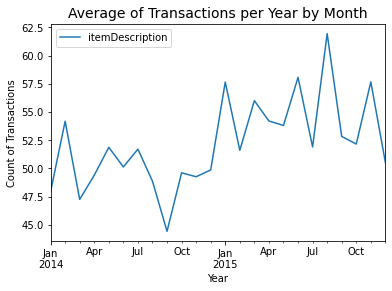

In [332]:
#get the number average of transaction ped month
df_time[['date',"itemDescription"]].groupby('date').count().resample('M').mean().plot()
plt.xlabel("Year", fontsize=10)
plt.ylabel("Count of Transactions", fontsize=10)
plt.title("Average of Transactions per Year by Month", fontsize=14);




We can observe that business is doing well as their is a trend of transactions been increase over time. |The graph above can help us gain some insight in seasonality. for example, it looks like October trend to be a slower month. 

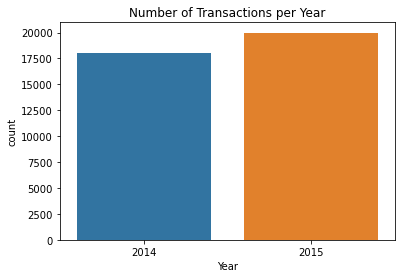

In [333]:
#plot counts of transaction per year
fig,ax = plt.subplots()
sns.countplot(data=df_time,x="Year")
ax.set(xlabel='Year',title="Number of Transactions per Year");

2015 have better sales that 2014. 

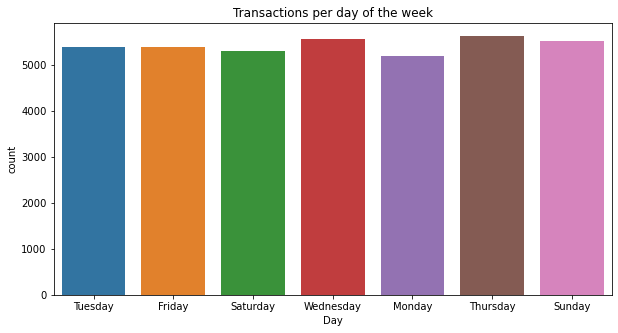

In [334]:
#plot counts of transaction for day of the Week
fig,ax = plt.subplots()
fig.set_size_inches(10,5)
sns.countplot(data=df_time,x="weekday")
ax.set(xlabel='Day',title="Transactions per day of the week");

It looks like Wednesday, Thursday, and Sundays are the busiest days. It is important for the business to be well stock in inventory and have full staff during these days. 

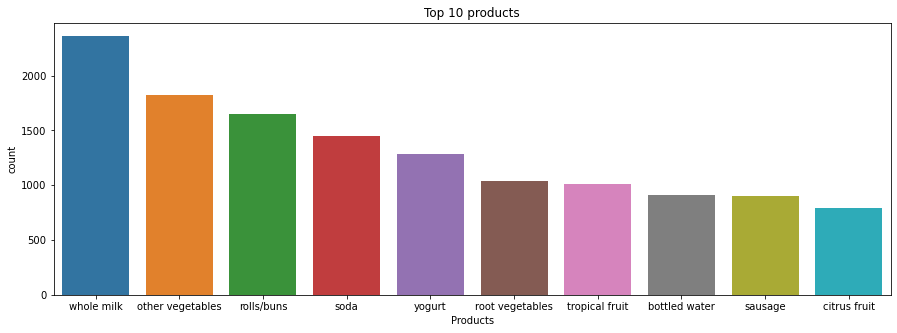

In [335]:
#plot top 10 products
fig,ax = plt.subplots()
fig.set_size_inches(15,5)
sns.countplot(data=df_time,x="itemDescription",order=df_time.itemDescription.value_counts().iloc[:10].index)
ax.set(xlabel='Products',title="Top 10 products");

Understanding the top 10 sellers is beneficial to make sure the business is well stock of this products. In addition, this can be main drivers for people to walk in to a store so they can use this to their advantage to cross sell with other products, improve product placement, and bundling opportunities.

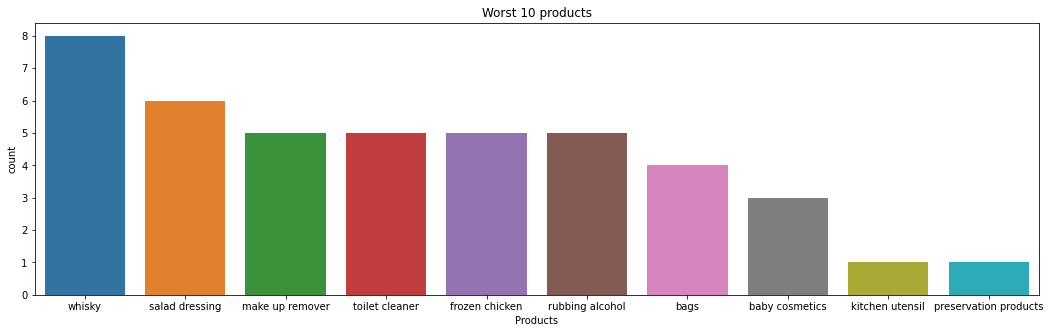

In [336]:
#plot 10 low selling products
fig,ax = plt.subplots()
fig.set_size_inches(18,5)
sns.countplot(data=df_time,x="itemDescription",order=df_time.itemDescription.value_counts().iloc[-10:].index)
ax.set(xlabel='Products',title="Worst 10 products");

It is important to understand low selling products. We might be able to increase the sales of this product by doing a proper basket analysis. In addition, Business can investigate further if is profitable to carrier these products. 

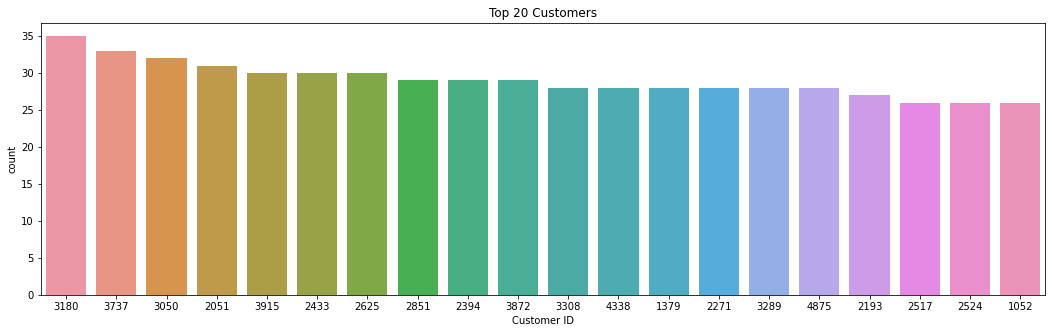

In [337]:
#plot top 20 customers
fig,ax = plt.subplots()
fig.set_size_inches(18,5)
sns.countplot(data=df_time,x="Member_number",order=df_time.Member_number.value_counts().iloc[:20].index)
ax.set(xlabel='Customer ID',title="Top 20 Customers");

From the plot above we can observe that top costumers tend two have a total of 35 -30 transaction from 2014 to 2015. 

### Apriori Algorithm

To do the Market Basket analysis i would use the Apriori Algorithm. I won't get into any detail for the math behind the algorithm.[Wikipedia has the exact details on how it works](https://en.wikipedia.org/wiki/Apriori_algorithm).

In the dataset, we can observe that each transaction item is record separately. For example, when a customer buy Whole Milk and Cookies it is recorded on the dataset as two rows.   

In order to do a market basket analysis it is important to group all the items that where purchase on the same transaction together. The best way to do this is by grouping the items by customer number and date.**I would go back to my original Data Frame (df_basket)**


In [37]:
items = df_basket.groupby(['Member_number', 'Date']).agg({'itemDescription': lambda x: x.ravel().tolist()}).reset_index()
items.head()
items.shape

(14963, 3)

In [39]:
# Import the transaction encoder function from mlxtend
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

# Instantiate transaction encoder and identify unique items in transactions
transactions = items["itemDescription"]
encoder = TransactionEncoder().fit(transactions)

# One-hot encode transactions
onehot = encoder.transform(transactions)

# Convert one-hot encoded data to DataFrame
onehot_basket = pd.DataFrame(onehot, columns = encoder.columns_)

# Print the one-hot encoded transaction dataset
onehot_basket.head()
onehot_basket.shape

(14963, 167)

### Determining Rules
Once our data is in the format above, we can begin to determine association rules.

Here, we calculate several metrics to analyse the rules. These are calculated automatically by the package, but we will take time to understand them.

First, all of our groups are designated as 'antecedents' and 'consequents'. This allows us to say: 'given this group of antecedents, we see this group of consequents with frequency x'. We will designate antecedents as  𝑋  and consequents as  𝑌  below.

Let's make some rules for illustration of these measures:


In [93]:
from mlxtend.frequent_patterns import association_rules

"""" we don't have a large enough dataset, so i only used .02 for support.
     For simplicity I used only a max_len of 2, if you want to see more than two
     items you can channge this rule"""

x = apriori(onehot_basket, min_support=.001,max_len=2,use_colnames=True)

#take a look at the help for ways we can use this function
df_rules = association_rules(x, metric="lift", min_threshold=1)
#take a look
df_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(tropical fruit),(UHT-milk),0.067767,0.021386,0.001537,0.022682,1.060617,8.785064e-05,1.001326
1,(UHT-milk),(tropical fruit),0.021386,0.067767,0.001537,0.071875,1.060617,8.785064e-05,1.004426
2,(brown bread),(beef),0.037626,0.033950,0.001537,0.040853,1.203301,2.597018e-04,1.007196
3,(beef),(brown bread),0.033950,0.037626,0.001537,0.045276,1.203301,2.597018e-04,1.008012
4,(beef),(citrus fruit),0.033950,0.053131,0.001804,0.053150,1.000349,6.297697e-07,1.000020
...,...,...,...,...,...,...,...,...,...
205,(yogurt),(soft cheese),0.085879,0.010025,0.001270,0.014786,1.474952,4.088903e-04,1.004833
206,(specialty bar),(yogurt),0.013968,0.085879,0.001203,0.086124,1.002863,3.434701e-06,1.000269
207,(yogurt),(specialty bar),0.085879,0.013968,0.001203,0.014008,1.002863,3.434701e-06,1.000041
208,(specialty chocolate),(tropical fruit),0.015973,0.067767,0.001337,0.083682,1.234846,2.542036e-04,1.017368


### Interpreting Metrics

We have a lot of of metrics in the data frame above and is important to understand this metrics and how to get insight from it.


**Support** allows us to see how often the basket occurs. We don't want to waste our time promoting strong links between items if only a few people buy them.

**Confidence** allows us to see the strength of the rule. What proportion of transactions with our first item also contain the other item (or items)? For example, how true are both items (beef and brown bread) occurred in a transaction together

**Lift** can be interpreted a measure of how much we potentially drive up the sales of the consequent by the relationship? In theory it can be seen as proportional to the increase of sales of the antecedent. For any value higher than 1, lift shows that there is actually an association **Higher Values has generally stronger association**

---
Additional Association Rules: Leverage and Conviction are less common options for assessing the strength of the co-occurrence relationship.

**Leverage** computes the difference between the observed frequency of X and Y appearing together and the frequency that would be expected if X and Y were independent. A leverage value of 0 indicates independence.

The rationale in a sales setting is to find out how many more units (items X and Y together) are sold than expected from the independent sales.

**Conviction** looks at the ratio of the expected frequency that the rule makes an incorrect prediction if X and Y were independent, divided by the observed frequency of incorrect predictions.This is how strongly consequents depend on antecedent. For example, if a customer does not buy beef, they will not buy brown bread.  



Let's take a look at some insight by products by sorting the top 5 items that are shop together

In [90]:
#sort the rules by support
df_rules.sort_values(by='support',ascending = False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
198,(sausage),(soda),0.060349,0.097106,0.005948,0.098560,1.014975,0.000088,1.001613
199,(soda),(sausage),0.097106,0.060349,0.005948,0.061253,1.014975,0.000088,1.000963
201,(yogurt),(sausage),0.085879,0.060349,0.005748,0.066926,1.108986,0.000565,1.007049
200,(sausage),(yogurt),0.060349,0.085879,0.005748,0.095238,1.108986,0.000565,1.010345
128,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,0.000536,1.016420


The product sausage an soda are the items with the higher support. Lets take a look **Sausage** to gain more  this insight can be applied to any products but for simplicity I will only do one. 

In [84]:
#Sort the dataset
sausage_insight = df_rules[df_rules['consequents'].astype(str).str.contains('sausage')]
sausage_insight = milk_insight.sort_values(by=['lift'],ascending = [False]).reset_index(drop = True)

sausage_insight.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(beverages),(sausage),0.016574,0.060349,0.001537,0.092742,1.536764,0.000537,1.035704
1,(curd),(sausage),0.033683,0.060349,0.002941,0.087302,1.446615,0.000908,1.029531
2,(frozen vegetables),(sausage),0.028002,0.060349,0.002072,0.073986,1.225966,0.000382,1.014726
3,(bottled beer),(sausage),0.045312,0.060349,0.003342,0.073746,1.222000,0.000607,1.014464
4,(yogurt),(sausage),0.085879,0.060349,0.005748,0.066926,1.108986,0.000565,1.007049


We can observe that beverage,curd,frozen vegetables,bottled beer, and yogurt drive the sales of sausage. Running promos and discount on these items can increase sales for sausages. This can be good insight if sausages are at the end of life and the stores want to get rid of them. 

In [99]:
df 
df_rules.sort_values(by=['lift'],ascending = [False]).reset_index(drop = True).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(specialty chocolate),(citrus fruit),0.015973,0.053131,0.001403,0.087866,1.653762,0.000555,1.038081
1,(citrus fruit),(specialty chocolate),0.053131,0.015973,0.001403,0.026415,1.653762,0.000555,1.010726
2,(tropical fruit),(flour),0.067767,0.009757,0.001069,0.015779,1.617141,0.000408,1.006118
3,(flour),(tropical fruit),0.009757,0.067767,0.001069,0.109589,1.617141,0.000408,1.046969
4,(beverages),(sausage),0.016574,0.060349,0.001537,0.092742,1.536764,0.000537,1.035704
5,(sausage),(beverages),0.060349,0.016574,0.001537,0.025471,1.536764,0.000537,1.009129
6,(napkins),(pastry),0.022121,0.051728,0.001738,0.078550,1.518529,0.000593,1.029109
7,(pastry),(napkins),0.051728,0.022121,0.001738,0.033592,1.518529,0.000593,1.011869
8,(processed cheese),(root vegetables),0.010158,0.069572,0.001069,0.105263,1.513019,0.000363,1.039891
9,(root vegetables),(processed cheese),0.069572,0.010158,0.001069,0.015370,1.513019,0.000363,1.005293


Lastly, I want to get insight of the products that have a high confidence and the highest lift scores. 


In [104]:
# lets check some basic stats of our rules. 
df_rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction
count,210.000000,210.000000,210.000000,210.000000,210.000000,2.100000e+02,210.000000
mean,0.045238,0.045238,0.001666,0.052092,1.165016,1.937097e-04,1.007440
std,0.031016,0.031016,0.000928,0.035145,0.151203,1.700523e-04,0.009483
min,0.007084,0.007084,0.001002,0.008210,1.000136,5.091755e-07,1.000005
25%,0.023592,0.023592,0.001136,0.026415,1.044134,6.499581e-05,1.001688
50%,0.037359,0.037359,0.001403,0.041638,1.116675,1.418098e-04,1.003983
75%,0.060349,0.060349,0.001671,0.069275,1.246844,2.692913e-04,1.009114
max,0.157923,0.157923,0.005948,0.176056,1.653762,9.078510e-04,1.046969


In [119]:
#sort by confidence and then lift
df_rules.sort_values(['confidence', 'lift'], ascending=[False,False ], inplace=True)
df_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
203,(semi-finished bread),(whole milk),0.009490,0.157923,0.001671,0.176056,1.114825,0.000172,1.022008
113,(detergent),(whole milk),0.008621,0.157923,0.001403,0.162791,1.030824,0.000042,1.005814
146,(ham),(whole milk),0.017109,0.157923,0.002740,0.160156,1.014142,0.000038,1.002659
180,(processed cheese),(rolls/buns),0.010158,0.110005,0.001470,0.144737,1.315734,0.000353,1.040610
176,(packaged fruit/vegetables),(rolls/buns),0.008488,0.110005,0.001203,0.141732,1.288421,0.000269,1.036967
186,(seasonal products),(rolls/buns),0.007084,0.110005,0.001002,0.141509,1.286395,0.000223,1.036698
128,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,0.000536,1.016420
175,(pot plants),(other vegetables),0.007819,0.122101,0.001002,0.128205,1.049991,0.000048,1.007002
130,(frozen meals),(other vegetables),0.016775,0.122101,0.002139,0.127490,1.044134,0.000090,1.006176
185,(red/blush wine),(rolls/buns),0.010493,0.110005,0.001337,0.127389,1.158028,0.000182,1.019922


### Findings

From the above we can observe the following: 

- Whole milk, rolls/buns and other vegetables tend to be frequently add on items. 
- We can place consequent items if possible next to the antecedent items to drive sales. 
- For items that can be place next to each other , like detergent and whole milk we can make sure that the layout of the stores are close to each others. . 

## conclusion
Using Apriori algorithm is a very useful technique to find associations between items. In addition, They are easy to implement and explain. However for more complex insights, such as the ones been used by Amazon, Google, Netflix we can use recommendation systems.  